In [119]:
import pandas as pd;
pd.set_option('display.max_columns', None)
import numpy as np;
import pycountry_convert
import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
data=pd.read_csv("C:/Users/Alex/Desktop/HotelCancellations/hotel_bookings.csv")

In [121]:

def handlingMissingValues(data):
    #Majority of data in company column are missing values. Replaced with no company
    data['company']=data['company'].fillna("No Company")
    #Missing values of Agents Investigation and imputation
    nullagents=data
    nullagents=nullagents[nullagents['agent'].isna()]

    #Renaming missing values of agent to no agent if they contact the hotels directly 
    data.loc[data['agent'].isna() & ((data['distribution_channel'] == 'Corporate') | (data['distribution_channel'] == 'Direct')), 'agent'] = "No Agent"
    data.loc[(data['agent'].isna()) & (data['distribution_channel']=='TA/TO'), 'agent']="TA/TO No Agent Number"
    #Dropping extra na's which there are few of
    data=data.dropna(subset=['agent'])
    data=data.dropna(subset=['country'])
    #Renaming undefined meals to unknown
    data.loc[data['meal']=="Undefined","meal"]="Unknown"
    
    print(data.isna().sum())

    return data


In [122]:
def date_features(data):
    #Combining arrival date cols to one datetime
    data['arrival_date']=pd.to_datetime(data['arrival_date_month']+' ' + data['arrival_date_day_of_month'].astype(str)+ ' ' + data['arrival_date_year'].astype(str),format='%B %d %Y')
    data=data.drop(['arrival_date_month','arrival_date_day_of_month','arrival_date_year'],axis=1)
    #Converting reservation status to datetime
    data['reservation_status_date']=pd.to_datetime(data['reservation_status_date'])

    #Creating an arrival season feature
    data['arrival_season']=np.select(
        [(data['arrival_date'].dt.month.isin([12,1,2])),
        (data['arrival_date'].dt.month.isin([3,4,5])),
        (data['arrival_date'].dt.month.isin([6,7,8])),
        (data['arrival_date'].dt.month.isin([9,10,11]))],
        ['Winter','Spring','Summer','Fall'], 
        default='Unknown')
    #Creating a arrival weekday feature
    data['arrival_weekday']=np.select(
        [(data['arrival_date'].dt.weekday==0),
        (data['arrival_date'].dt.weekday==1),
        (data['arrival_date'].dt.weekday==2),
        (data['arrival_date'].dt.weekday==3),
        (data['arrival_date'].dt.weekday==4),
        (data['arrival_date'].dt.weekday==5),
        (data['arrival_date'].dt.weekday==6)],
        ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], default='Unknown'
    )
    #Creating an arrival year and month feature
    data['arrival_ym']=data['arrival_date'].dt.to_period('M')
    #Calculating the length of stay
    data['length_of_stay']=data['stays_in_week_nights']+data['stays_in_weekend_nights']
    #Calculating the expected departure date
    data['expected_date_of_departure']=data['arrival_date']+pd.to_timedelta(data['length_of_stay'],unit="D")
    #Creating expected departure season feature
    data['expected_departure_season']=np.select(
        [(data['expected_date_of_departure'].dt.month.isin([12,1,2])),
        (data['expected_date_of_departure'].dt.month.isin([3,4,5])),
        (data['expected_date_of_departure'].dt.month.isin([6,7,8])),
        (data['expected_date_of_departure'].dt.month.isin([9,10,11]))],
        ['Winter','Spring','Summer','Fall'], 
        default='Unknown')
    #Creating expected departure weekday
    data['expected_departure_weekday']=np.select(
        [(data['expected_date_of_departure'].dt.weekday==0),
        (data['expected_date_of_departure'].dt.weekday==1),
        (data['expected_date_of_departure'].dt.weekday==2),
        (data['expected_date_of_departure'].dt.weekday==3),
        (data['expected_date_of_departure'].dt.weekday==4),
        (data['expected_date_of_departure'].dt.weekday==5),
        (data['expected_date_of_departure'].dt.weekday==6)],
        ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], default='Unknown'
    )
    #Creating expected departure year and month
    data['expected_departure_ym']=data['expected_date_of_departure'].dt.to_period('M')
    #Checking if the arrival and departure season are the same
    data['same_season_stay']=data.apply(lambda x: 1 if x['arrival_season']==x['expected_departure_season'] else 0, axis=1)

    return data



In [123]:
def continent(country_iso3c):
    #Converts Country iso codees to continent codes
    try:
        country_iso2c = pycountry_convert.country_alpha3_to_country_alpha2(country_iso3c)
        continent_name = pycountry_convert.country_alpha2_to_continent_code(country_iso2c)
        return continent_name
    
    except Exception as e:
        return None

def country_features(data):
        #Converting China to it's iso3c code instead of iso2c
        data.loc[data['country'] == "CN", 'country'] = "CHN"
        data['continent'] = data['country'].apply(continent)
        return data




In [124]:
def guest_number_features(data):
    #Calculating features related to the number of guests
    data['total_amount_of_guests']=data['adults']+data['children']+data['babies']
    data['babies_prop']=data['babies']/data['total_amount_of_guests']
    data['adults_prop']=data['adults']/data['total_amount_of_guests']
    data['children_prop']=data['children']/data['total_amount_of_guests']
    data['solo_travel']=data.apply(lambda x:1 if x['total_amount_of_guests']==1 else 0, axis=1)
    return data




In [125]:
def indicator_features(data):
     #Creating indicator features for requests from the guests
     data['car_parking_spaces_ind']=data.apply(lambda x: 1 if x['required_car_parking_spaces']>0 else 0, axis=1)
     data['special_requests_ind']=data.apply(lambda x: 1 if x['total_of_special_requests']>0 else 0, axis=1)
     data['waiting_list_ind']=data.apply(lambda x: 1 if x['days_in_waiting_list']>0 else 0, axis=1)
     data['booking_changes_ind']=data.apply(lambda x: 1 if x['booking_changes']>0 else 0, axis=1)
     data['previous_cancellations_ind']=data.apply(lambda x: 1 if x['previous_cancellations']>0 else 0, axis=1)
     data['previous_not_canceled_ind']=data.apply(lambda x: 1 if x['previous_bookings_not_canceled']>0 else 0, axis=1)
     data['day_use_ind']=data.apply(lambda x: 1 if x['length_of_stay']==1 else 0, axis=1)
     return data




In [126]:
def binning_features(data):
    #Binning lead time for better clarity
    data['lead_time_quartiles']=pd.qcut(data['lead_time'],q=4,labels=['Q1','Q2','Q3','Q4'])
    return data



In [127]:
def extra_features(data):
    #Creating an expected total revenue feature
    data['expected_total_revenue']=data['length_of_stay']*data['adr']
    return data




In [128]:
def dropped_features(data):
    #Dropping unneeded features that were used to engineer features
    data=data.drop(columns=['agent','country','company','reservation_status','reservation_status_date','lead_time','stays_in_weekend_nights','stays_in_week_nights','arrival_date','expected_date_of_departure','arrival_ym','expected_departure_ym','arrival_date_week_number','adults','babies','children'])
    return data




In [129]:
def correlation_plot(data):
    #Correlation plot
    f = plt.figure(figsize=(19, 15))
    numeric_data=data.select_dtypes(include=[np.number])
    cor=numeric_data.corr()
    sns.heatmap(cor,annot=True, fmt='.2f') 
    plt.show()
    #Dropping highly correlated features
    upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
    cols_dropped=[column for column in upper.columns if any(abs(upper[column]) >=0.70)]
    data=data.drop(cols_dropped,axis=1)
    print("Dropped Columns due to high correlation")
    print(cols_dropped)
    
    return data
    



In [130]:
def converting_datatypes(data):
    #Converting features to appropriate datatypes
    data["hotel"] = data["hotel"].astype("category")
    data["is_canceled"] = data["is_canceled"].astype("category")
    data["meal"] = data["meal"].astype("category")
    data["market_segment"] = data["market_segment"].astype("category")
    data["distribution_channel"] = data["distribution_channel"].astype("category")
    data["is_repeated_guest"] = data["is_repeated_guest"].astype("category")
    data["previous_cancellations"] = data["previous_cancellations"].astype(int)
    data["previous_bookings_not_canceled"] = data["previous_bookings_not_canceled"].astype(float)
    data["reserved_room_type"] = data["reserved_room_type"].astype("category")
    data["assigned_room_type"] = data["assigned_room_type"].astype("category")
    data["booking_changes"] = data["booking_changes"].astype(int)
    data["days_in_waiting_list"] = data["days_in_waiting_list"].astype(int)
    data["customer_type"] = data["customer_type"].astype("category")
    data["adr"] = data["adr"].astype(float)
    data["required_car_parking_spaces"] = data["required_car_parking_spaces"].astype(int)
    data["total_of_special_requests"] = data["total_of_special_requests"].astype(int)
    data["arrival_season"] = data["arrival_season"].astype("category")
    data['deposit_type']=data['deposit_type'].astype("category")
    data["arrival_weekday"] = data["arrival_weekday"].astype("category")
    data["length_of_stay"] = data["length_of_stay"].astype(int)
    data["expected_departure_season"] = data["expected_departure_season"].astype("category")
    data["expected_departure_weekday"] = data["expected_departure_weekday"].astype("category")
    data["same_season_stay"] = data["same_season_stay"].astype("category")
    data["continent"] = data["continent"].astype("category")
    data["total_amount_of_guests"] = data["total_amount_of_guests"].astype(int)
    data["babies_prop"] = data["babies_prop"].astype(float)
    data["adults_prop"] = data["adults_prop"].astype(float)
    data["solo_travel"] = data["solo_travel"].astype("category")
    data["previous_cancellations_ind"] = data["previous_cancellations_ind"].astype("category")
    data["day_use_ind"] = data["day_use_ind"].astype("category")
    data["lead_time_quartiles"] = data["lead_time_quartiles"].astype("category")

    return data



hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          2
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

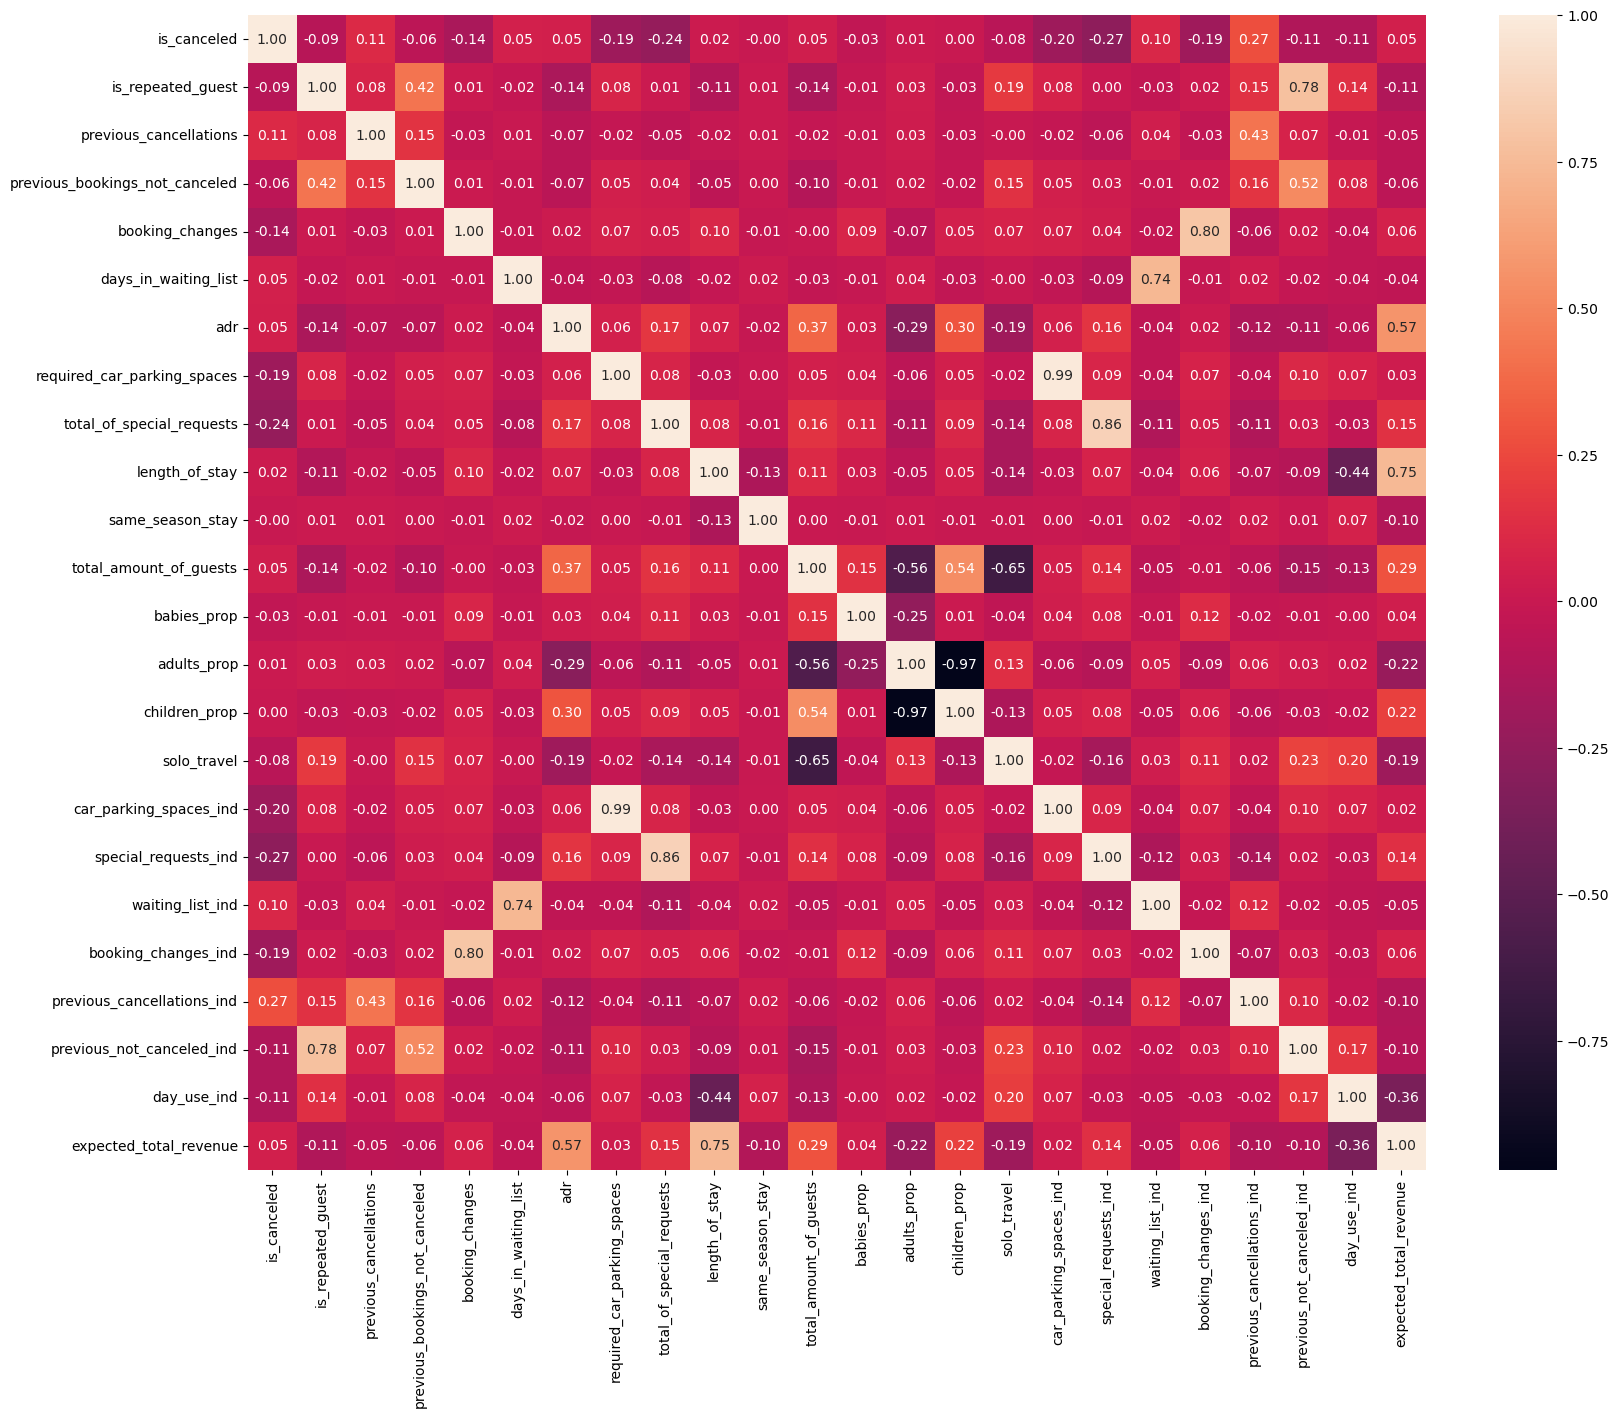

Dropped Columns due to high correlation
['children_prop', 'car_parking_spaces_ind', 'special_requests_ind', 'waiting_list_ind', 'booking_changes_ind', 'previous_not_canceled_ind', 'expected_total_revenue']


In [131]:
data=handlingMissingValues(data)
data=date_features(data)

data = country_features(data)
#Dropping any missing values due to the coujntry not being associated with a continent
data=data.dropna()
data=guest_number_features(data)
data=indicator_features(data)
data=binning_features(data)
data=extra_features(data)
data=dropped_features(data)
data=correlation_plot(data)
data=data.dropna()
data.to_csv("CleanedHotel_bookings.csv", index=False)
